In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as ms

ms.use('seaborn-muted')
%matplotlib inline
import librosa
import librosa.display

# загрузка mp3 файлов
import audioread.ffdec  # Use ffmpeg decoder
import ffmpeg

from glob import glob
import os

#pytorch
import torch
import torch.nn as nn
from torchvision import transforms

from PIL import Image

In [2]:
songs_dir = './music'
songs_names = glob(songs_dir+ "\*.mp3")
y, sr = librosa.load(audioread.ffdec.FFmpegAudioFile(songs_names[0]))

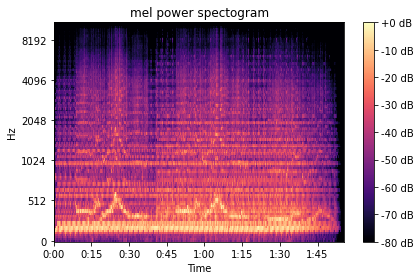

In [3]:
#Mel Spectogram
S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = 128)

#convert to log scale
log_S = librosa.power_to_db(S, ref = np.max)

#display the spectogram on a mel scale
# sample rate and hop length parameters are used to rener the time axis
librosa.display.specshow(log_S, sr = sr, x_axis = 'time', y_axis = 'mel')

plt.title('mel power spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

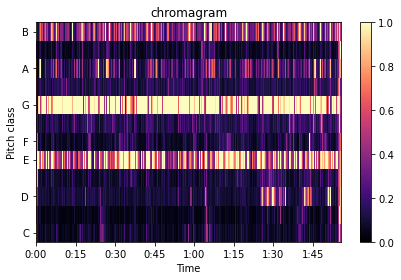

In [4]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

C = librosa.feature.chroma_cqt(y=y_harmonic, sr = sr)

librosa.display.specshow(C, sr=sr, x_axis='time', y_axis = 'chroma', vmin = 0, vmax = 1)

plt.title("chromagram")
plt.colorbar()
plt.tight_layout()

In [2]:
songs_dir = './csv_data'
songs_names = glob(songs_dir+ "\*.csv")


In [8]:
torch.ToTensor()

AttributeError: module 'torch' has no attribute 'ToTensor'

In [6]:
def load_cens_pandas(load_dir):
    df = pd.DataFrame()
    songs_names = glob(songs_dir+ "\*.csv")
    train_songs_names= [song.split('\\')[-1].split('.')[0] for song in songs_names]
    y_dict_reverse = {i : train_songs_names[i] for i in range(len(train_songs_names))}
    for i, song_name in enumerate(songs_names):
        df_to_merge = pd.read_csv(song_name, skiprows = 1, header = None)
        df_to_merge['y'] = np.full(len(df_to_merge), i) 
        df = pd.concat([df, df_to_merge])
    return y_dict_reverse, df

In [14]:
csv_dir = './csv_data'    
rev_dict, df = load_cens_pandas(csv_dir)
X = df.drop('y', axis = 1)
y = df['y']

In [152]:
class CENSDataset(torch.utils.data.Dataset):   
    def __init__(self, dir_names):
        
        self.transform = transforms.Compose(
            [
                #transforms.Resize((10,10)), 
                transforms.ToTensor()
            ]
        )
        data = []
        y = []
        self.dir_names = dir_names
        
        train_songs_names= [song.split('\\')[-1] for song in dir_names]
        
        self.y_dict_reverse = {i : train_songs_names[i] for i in range(len(train_songs_names))}
        for i, dir_name in enumerate(dir_names):
            song_names = glob(dir_name + "\*.jpeg")
            for song in song_names:
                img = Image.open(song)
                data.append(self.transform(img))
                y.append(i)
        
        self.data = torch.cat(data).unsqueeze(1)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        
        img = self.data[index]      
        target = self.y[index]
        
        return img, target
    
    def get_number_of_classes(self):
        return len(np.unique(self.y))

In [232]:
csv_dir = './images' 
disk_data = r"D:\data\zamzam\\"
directories = [song[0] for song in os.walk(disk_data)][1:]
dataset = CENSDataset(directories)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [12500, 1234])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

# 1

In [239]:

#1
num_class = data.get_number_of_classes()
pooling_layer = nn.MaxPool2d(kernel_size=2)
m = nn.Conv2d(1, 20, (1, 7), stride=(1, 3))
output = m(data[:][0])

m = nn.Conv2d(20, 50, (1, 7), stride=(1, 3))
output = m(output)
m = nn.Conv2d(50, 100, (3, 6),stride = (1,3))
output = m(output)
m = nn.Conv2d(100, 200, (2, 2))
output = m(output)
output = pooling_layer1(output)
m = nn.Conv2d(200, 400, (2, 2))
output = m(output)
output = pooling_layer1(output)

output = torch.flatten(output, 1)
m = nn.Linear(in_features=400, out_features=400)
output = m(output)
m = nn.Linear(in_features=400, out_features=num_class)
output = m(output)
output.size()



torch.Size([772, 5])

In [234]:
class NN(nn.Module):
    def __init__(self, num_class):
        super(NN, self).__init__()
        
        self.num_class = num_class
        
        self.batchnorm_0 = torch.nn.BatchNorm2d(1)
        self.conv_layer1 = nn.Conv2d(1, 40, (1, 7), stride=(1, 3))#20
        
        self.conv_layer2 = nn.Conv2d(40, 100, (1, 7), stride=(1, 3))#50
        
        self.conv_layer3 = nn.Conv2d(100, 200, (3, 6),stride = (1,3))#100
        
        self.conv_layer4 = nn.Conv2d(200, 400, (2, 2))#200
        
        self.conv_layer5 = nn.Conv2d(400, 800, (2, 2))#400
        
        self.linear_layer1 = nn.Linear(in_features=800, out_features=800)
        
        self.linear_layer2 = nn.Linear(in_features=800, out_features=self.num_class)
        
        self.pooling_layer = nn.MaxPool2d(kernel_size=2)
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, inputs):
        res = self.batchnorm_0(inputs)
        res = self.relu(self.conv_layer1(res))
        
        res = self.relu(self.conv_layer2(res))
        
        res = self.relu(self.conv_layer3(res))
        
        res = self.relu(self.conv_layer4(res))
        res = self.pooling_layer(res)
        
        res = self.relu(self.conv_layer5(res))
        res = self.pooling_layer(res)
        
        res = torch.flatten(res, 1)
        
        res = self.relu(self.linear_layer1(res))
        
        
        res = self.linear_layer2(res)
        return res

In [235]:
np.random.seed(42)
torch.manual_seed(42)

model = NN(dataset.get_number_of_classes())

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

num_epochs = 400
history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    for num_batch, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels.reshape(-1, 1)      
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, torch.flatten(labels))   
        loss.backward()
        optimizer.step()
    #if epoch % 10 == 0:
    #    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            pred = model(images)
            for i, pr in enumerate(pred):
                if torch.argmax(pr) == labels[i]:
                    correct += 1
            total += len(pred)
            
        history.append(100 * correct / total)
        print(f'Epoch: {epoch}, Accuracy: {100 * correct / total:.4f} %')

Epoch: 1, Accuracy: 1.5397 %
Epoch: 2, Accuracy: 3.7277 %
Epoch: 3, Accuracy: 3.7277 %
Epoch: 4, Accuracy: 3.7277 %
Epoch: 5, Accuracy: 3.7277 %
Epoch: 6, Accuracy: 3.7277 %
Epoch: 7, Accuracy: 3.7277 %
Epoch: 8, Accuracy: 3.7277 %
Epoch: 9, Accuracy: 3.7277 %
Epoch: 10, Accuracy: 3.7277 %
Epoch: 11, Accuracy: 3.7277 %
Epoch: 12, Accuracy: 3.4846 %
Epoch: 13, Accuracy: 3.8898 %
Epoch: 14, Accuracy: 3.8898 %
Epoch: 15, Accuracy: 4.3760 %
Epoch: 16, Accuracy: 3.9708 %
Epoch: 17, Accuracy: 4.1329 %
Epoch: 18, Accuracy: 4.2139 %
Epoch: 19, Accuracy: 4.0519 %
Epoch: 20, Accuracy: 4.3760 %
Epoch: 21, Accuracy: 3.9708 %
Epoch: 22, Accuracy: 4.0519 %
Epoch: 23, Accuracy: 4.5381 %
Epoch: 24, Accuracy: 5.0243 %
Epoch: 25, Accuracy: 5.2674 %
Epoch: 26, Accuracy: 5.7536 %
Epoch: 27, Accuracy: 4.9433 %
Epoch: 28, Accuracy: 5.4295 %
Epoch: 29, Accuracy: 6.0778 %
Epoch: 30, Accuracy: 6.2399 %
Epoch: 31, Accuracy: 5.9968 %
Epoch: 32, Accuracy: 6.2399 %
Epoch: 33, Accuracy: 5.6726 %
Epoch: 34, Accuracy

Epoch: 262, Accuracy: 69.2058 %
Epoch: 263, Accuracy: 67.3420 %
Epoch: 264, Accuracy: 65.2350 %
Epoch: 265, Accuracy: 58.5900 %
Epoch: 266, Accuracy: 69.6110 %
Epoch: 267, Accuracy: 68.9627 %
Epoch: 268, Accuracy: 68.9627 %
Epoch: 269, Accuracy: 68.9627 %
Epoch: 270, Accuracy: 69.1248 %
Epoch: 271, Accuracy: 69.8541 %
Epoch: 272, Accuracy: 68.9627 %
Epoch: 273, Accuracy: 68.3955 %
Epoch: 274, Accuracy: 65.1540 %
Epoch: 275, Accuracy: 68.8817 %
Epoch: 276, Accuracy: 70.7455 %
Epoch: 277, Accuracy: 61.5883 %
Epoch: 278, Accuracy: 68.8817 %
Epoch: 279, Accuracy: 67.1799 %
Epoch: 280, Accuracy: 68.8817 %
Epoch: 281, Accuracy: 67.2609 %
Epoch: 282, Accuracy: 68.2334 %
Epoch: 283, Accuracy: 69.9352 %
Epoch: 284, Accuracy: 69.7731 %
Epoch: 285, Accuracy: 67.3420 %
Epoch: 286, Accuracy: 69.9352 %
Epoch: 287, Accuracy: 69.7731 %
Epoch: 288, Accuracy: 66.0454 %
Epoch: 289, Accuracy: 69.3679 %
Epoch: 290, Accuracy: 71.9611 %
Epoch: 291, Accuracy: 68.3144 %
Epoch: 292, Accuracy: 67.9903 %
Epoch: 2

KeyboardInterrupt: 

74.47325769854133


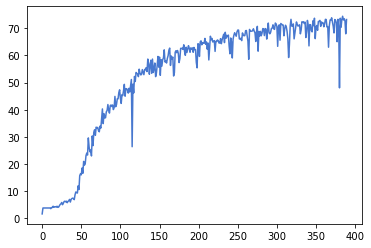

In [236]:
print(max(history))
plt.plot(history)

In [237]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        pred = model(images)
        for i, pr in enumerate(pred):
            if torch.argmax(pr) == labels[i]:
                correct += 1
        total += len(pred)

    print(f'Epoch: {epoch}, Accuracy: {100 * correct / total:.4f} %')

Epoch: 391, Accuracy: 73.2577 %


# 2

In [279]:
#2
num_class = data.get_number_of_classes()
max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)

m = nn.Conv2d(1, 20, (1, 8), stride=(1, 2))
output = m(data[:][0])
output = av_pooling_layer_1(output)
"""
m = nn.Conv2d(20, 50, (1, 4), stride=(1, 2))
output = m(output)
output = max_pooling_layer_1(output)

m = nn.Conv2d(50, 100, (4, 2))
output = m(output)
output = max_pooling_layer_1(output)

m = nn.Conv2d(100, 200, (2, 2))
output = m(output)
output = max_pooling_layer_2(output)

m = nn.Conv2d(200, 400, (2, 2))
output = m(output)
output = max_pooling_layer_2(output)"""
output.size()

torch.Size([772, 20, 12, 79])

In [277]:
class NN2(nn.Module):
    def __init__(self, num_class):
        super(NN2, self).__init__()
        
        self.num_class = num_class
        
        self.batchnorm_0 = torch.nn.BatchNorm2d(1)
        self.conv_layer1 = nn.Conv2d(1, 20, (1, 8), stride=(1, 2))#20
        
        self.conv_layer2 = nn.Conv2d(20, 40, (1, 4), stride=(1, 2))#50
        
        self.conv_layer3 = nn.Conv2d(40, 80, (4, 2))#100
        
        self.conv_layer4 = nn.Conv2d(80, 160, (2, 2))#200
        
        self.conv_layer5 = nn.Conv2d(160, 320, (2, 2))#400
        
        self.linear_layer1 = nn.Linear(in_features=320, out_features=320)
        
        self.linear_layer2 = nn.Linear(in_features=320, out_features=self.num_class)
        
        self.max_pooling_layer_1 = nn.MaxPool2d(kernel_size = (1,2), stride=(1,2))
        self.av_pooling_layer_1 = nn.AvgPool2d(kernel_size = (1,2), stride=(1,2))

        self.max_pooling_layer_2 = nn.MaxPool2d(kernel_size = 2)
        self.av_pooling_layer_2 = nn.AvgPool2d(kernel_size = 2)
        
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        
    def forward(self, inputs):
        res = self.batchnorm_0(inputs)
        res = self.relu(self.conv_layer1(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer2(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer3(res))
        res = self.max_pooling_layer_1(res)
        
        res = self.relu(self.conv_layer4(res))
        res = self.max_pooling_layer_2(res)
        
        res = self.relu(self.conv_layer5(res))
        res = self.max_pooling_layer_2(res)
        
        res = torch.flatten(res, 1)
        
        res = self.relu(self.linear_layer1(res))
        
        res = self.linear_layer2(res)
        return res

In [278]:
np.random.seed(42)
torch.manual_seed(42)

model = NN2(dataset.get_number_of_classes())

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

num_epochs = 100
history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    for num_batch, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels.reshape(-1, 1)      
        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, torch.flatten(labels))   
        loss.backward()
        optimizer.step()
    #if epoch % 10 == 0:
    #    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            pred = model(images)
            for i, pr in enumerate(pred):
                if torch.argmax(pr) == labels[i]:
                    correct += 1
            total += len(pred)
            
        history.append(100 * correct / total)
        print(f'Epoch: {epoch}, Accuracy: {100 * correct / total:.4f} %')

Epoch: 1, Accuracy: 3.9708 %


KeyboardInterrupt: 

80.06482982171799


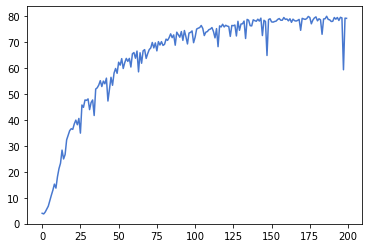

In [272]:
print(max(history))
plt.plot(history)